# Intro Spectral Clustering

In this notebook we want to explore the ideas behind spectral clustering. We do not focus on the theory, as there are many good and complete resources on the topic. For an introduction/overview I recommend the lecture notes [A Tutorial on Spectral Clustering](http://www.tml.cs.uni-tuebingen.de/team/luxburg/publications/Luxburg07_tutorial.pdf) by [Prof. Dr. Ulrike von Luxburg](http://www.tml.cs.uni-tuebingen.de/team/luxburg/index.php). 

https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py

## Prepare Notebook

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Generate Sample Data

Let us generate some sample data as concentriic circles:

In [3]:
# Set random state. 
rs = np.random.RandomState(42)

def generate_circle_sample_data(r, n, sigma):
    """Generate circle data with random gaussian noise."""
    angles = rs.uniform(low=0, high=2*np.pi, size=n)

    x_epsilon = rs.normal(loc=0.0, scale=sigma, size=n)
    y_epsilon = rs.normal(loc=0.0, scale=sigma, size=n)

    x = r*np.cos(angles) + x_epsilon
    y = r*np.sin(angles) + y_epsilon
    
    return x, y


def generate_concentric_circles_data(param_list):
    """Generates many circle data with random gaussian noise."""
    coordinates = [ 
        generate_circle_sample_data(param[0], param[1], param[2])
     for param in param_list
    ]
    
    return coordinates

Let us plot some examples to see how the parameters affect the data structure and clusters. 

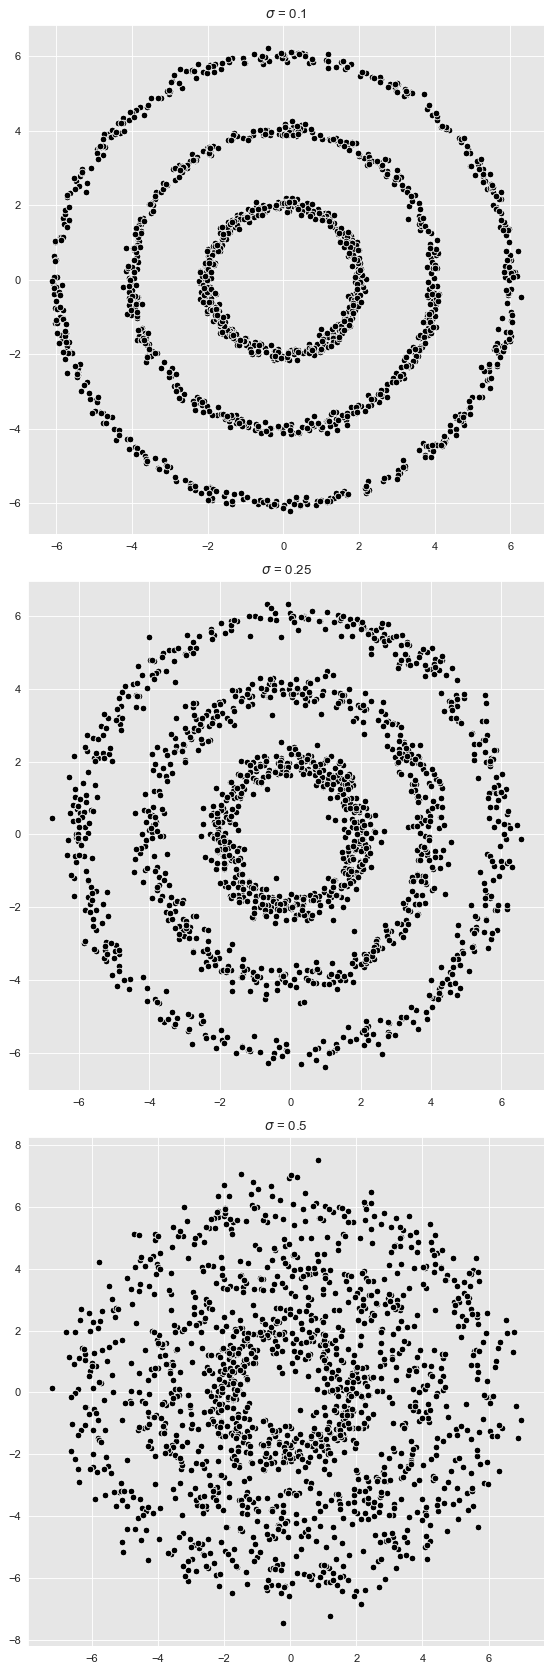

In [42]:
# Set global plot parameters. 
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['figure.dpi'] = 80

# Number of points per circle. 
n = 500
# Radius. 
r_list =[2, 4, 6]
# Number of samples. 
n = 500
# Standar deviatoin gaussian noise. 
sigmas = [0.1, 0.25, 0.5]

param_lists = [[(r, n, sigma) for r in r_list] for sigma in sigmas] 


fig, axes = plt.subplots(3, 1, figsize=(7, 21))

for i, param_list in enumerate(param_lists):

    coordinates = generate_concentric_circles_data(param_list)
    
    ax = axes[i]
    
    for j in range(0, len(coordinates)):
    
        x, y = coordinates[j]
        sns.scatterplot(x=x, y=y, ax=ax, color='k')
        ax.set(title=f'$\sigma$ = {param_list[0][2]}')

plt.tight_layout()

## Example 1: Well-defined Clusters

We consider sample data with the parameters defined above with `sigma` = 0.1. Note from the plots above that in this case the clusters separate well. 

In [43]:
coordinates = generate_concentric_circles_data(param_lists[0])

In [72]:
from itertools import chain

def data_frame_from_coordinates(coordinates): 
    """From coordinates to data frame."""
    xs = chain(*[c[0] for c in coordinates])
    ys = chain(*[c[1] for c in coordinates])

    return pd.DataFrame(data={'x': xs, 'y': ys})

data_df = data_frame_from_coordinates(coordinates)

In [73]:
from sklearn.neighbors import kneighbors_graph
from scipy import sparse

def generate_graph_laplacian(df, nn):
    """Generate graph laplacian from data."""
    # Adjacency Matrix.
    connectivity = kneighbors_graph(X=df, n_neighbors=nn, mode='connectivity')
    adjacency_matrix_s = (1/2)*(connectivity + connectivity.T)
    # Graph Laplacian.
    graph_laplacian_s = sparse.csgraph.laplacian(csgraph=adjacency_matrix_s, normed=False)
    graph_laplacian = graph_laplacian_s.toarray()
    
    return graph_laplacian 
    
graph_laplacian = generate_graph_laplacian(df=data_df, nn=8)

In [74]:
from scipy import linalg
eigenvals, eigenvcts = linalg.eig(graph_laplacian)

eigenvals = np.real(eigenvals)
eigenvcts = np.real(eigenvcts)

In [75]:
#eigenvals, eigenvcts = sparse.linalg.eigs(A=graph_laplacian_s, k=200)

In [76]:
eigenvals_indices = np.argsort(eigenvals)
eigenvals_sorted = eigenvals[eigenvals_indices]

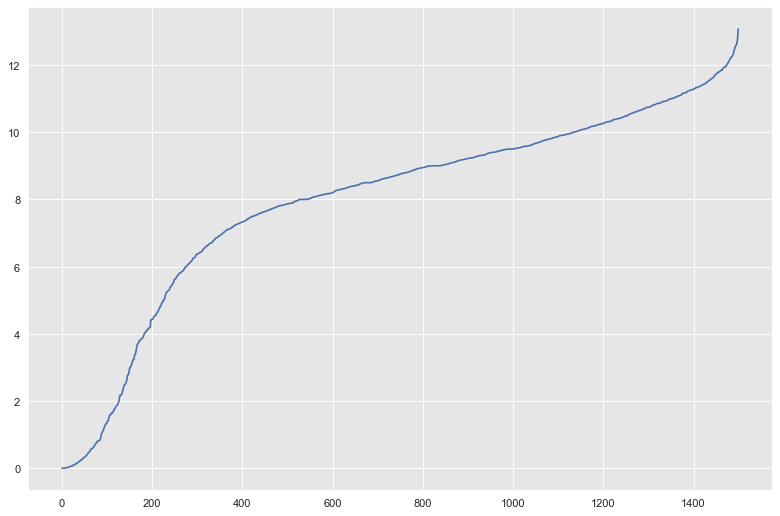

In [77]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.lineplot(x=list(range(0, eigenvals_sorted.size)), y=eigenvals_sorted, ax=ax)

In [13]:
zero_eigenvals_index = np.argwhere(abs(eigenvals) < 1e-5)

In [14]:
eigenvals[zero_eigenvals_index ]

array([[ 8.90780505e-16],
       [-8.67361738e-18],
       [-3.51189756e-16]])

In [15]:
df = pd.DataFrame(eigenvcts[:, zero_eigenvals_index .squeeze()])

df.columns = ['v_' + str(c) for c in df.columns]

df.head()

,v_0,v_1,v_2
0,0.044721,0.0,0.0
1,0.044721,0.0,0.0
2,0.044721,0.0,0.0
3,0.044721,0.0,0.0
4,0.044721,0.0,0.0


In [16]:
from sklearn.cluster import KMeans

inertias = []

k_candidates = range(1, 6)

for k in k_candidates:
    k_means = KMeans(random_state=42, n_clusters=k)
    k_means.fit(df)
    inertias.append(k_means.inertia_)

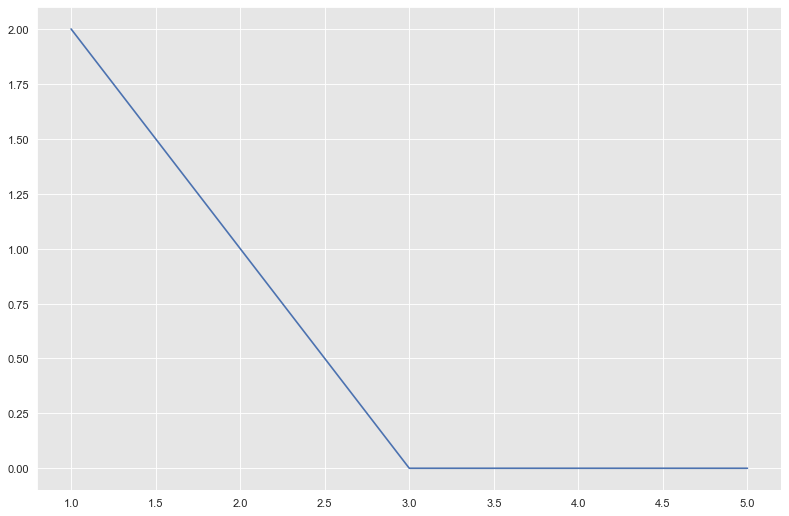

In [17]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x=k_candidates, y = inertias, ax=ax)

In [18]:
k_means = KMeans(random_state=42, n_clusters=3)
k_means.fit(np.real(df.values))
cluster = k_means.predict(np.real(df.values))

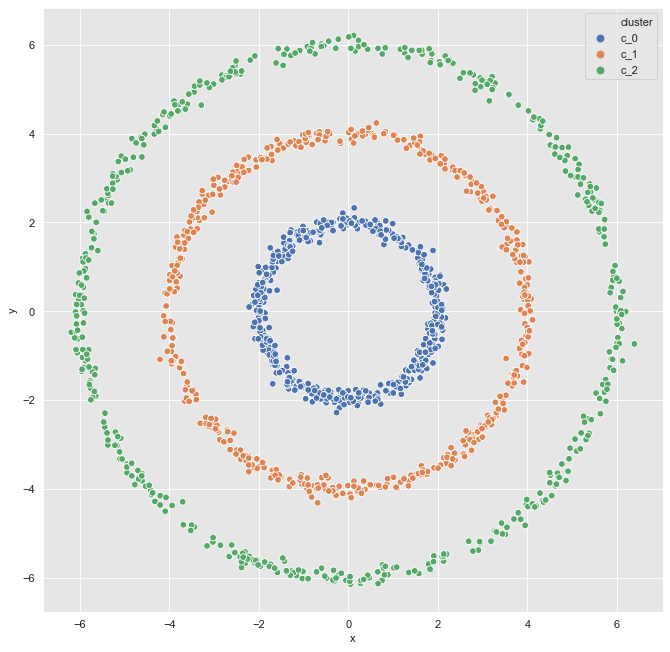

In [19]:
data_df['cluster'] = ['c_' + str(c) for c in cluster]

fig, ax = plt.subplots()

sns.scatterplot(x='x', y='y', data=data_df, hue='cluster', ax=ax)

In [20]:
def compute_graph_laplacian(df, n_neighbors):
    connectivity = kneighbors_graph(X=df, n_neighbors=n_neighbors, mode='connectivity')
    adjacency_matrix_s = (1/2)*(connectivity + connectivity.T)
    graph_laplacian_s = sparse.csgraph.laplacian(csgraph=adjacency_matrix_s, normed=False)
    graph_laplacian = graph_laplacian_s.toarray()
    return graph_laplacian

def compute_spectrum_graph_laplacian(graph_laplacian):
    eigenvals, eigenvcts = linalg.eig(graph_laplacian)
    eigenvals = np.real(eigenvals)
    eigenvcts = np.real(eigenvcts)
    return eigenvals, eigenvcts

def project_and_transpose(eigenvals, eigenvcts, threshold=1e-5):
    zero_eigenvals_index = np.argwhere(abs(eigenvals) < threshold)
    df = pd.DataFrame(eigenvcts[:, zero_eigenvals_index .squeeze()])
    df.columns = ['v_' + str(c) for c in df.columns]
    return df
    
def run_k_means(df, n_clusters):
    k_means = KMeans(random_state=42, n_clusters=n_clusters)
    k_means.fit(df)
    cluster = k_means.predict(df)
    return cluster

def spectral_clusterinig(df, n_neighbors, n_clusters, threshold=1e-5):
    graph_laplacian = compute_graph_laplacian(df, n_neighbors)
    eigenvals, eigenvcts = compute_spectrum_graph_laplacian(graph_laplacian)
    proj_df = project_and_transpose(eigenvals, eigenvcts, threshold=threshold)
    cluster = run_k_means(proj_df, n_clusters)
    return ['c_' + str(c) for c in cluster]

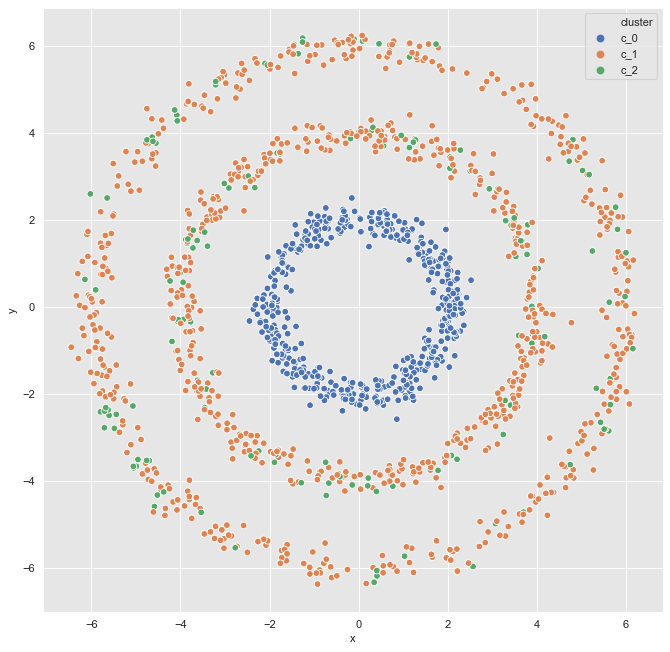

In [21]:
coordinates = generate_concentric_circles_data(r_list, n_list, [0.2]*len(r_list))
data_df = data_frame_from_coordinates(coordinates)

data_df['cluster'] = spectral_clusterinig(df=data_df, n_neighbors=8, n_clusters=3)

fig, ax = plt.subplots()
sns.scatterplot(x='x', y='y', data=data_df, hue='cluster', ax=ax)

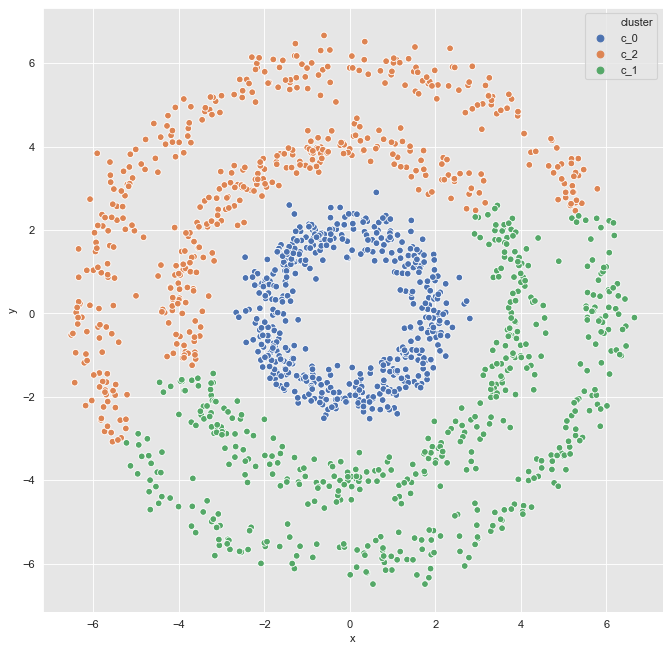

In [26]:
coordinates = generate_concentric_circles_data(r_list, n_list, [0.3]*len(r_list))
data_df = data_frame_from_coordinates(coordinates)

data_df['cluster'] = spectral_clusterinig(df=data_df, n_neighbors=8, n_clusters=3, threshold=1e-2)

fig, ax = plt.subplots()
sns.scatterplot(x='x', y='y', data=data_df, hue='cluster', ax=ax)

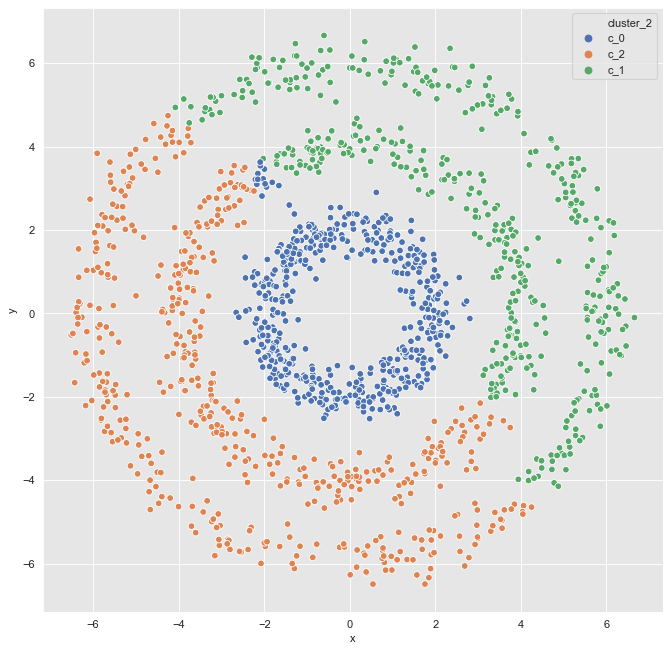

In [28]:
from sklearn.cluster import SpectralClustering

spec_cl = SpectralClustering(n_clusters=3, random_state=42, n_neighbors=8, affinity='nearest_neighbors')
data_df['cluster_2'] = spec_cl.fit_predict(data_df[['x', 'y']])
data_df['cluster_2'] = ['c_' + str(c) for c in data_df['cluster_2']]

fig, ax = plt.subplots()
sns.scatterplot(x='x', y='y', data=data_df, hue='cluster_2', ax=ax)